# Evasion attacks against Machine Learning models

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/zangobot/teaching_material/blob/HEAD/01-Evasion.ipynb)

As seen in class, machine learning models can be fooled by *adversarial examples*, samples artificially crafted to redirect the output of the victim towards a desired result.

These attacks can be either:

* **targeted**, in which the attacker wants to produce a specific misclassification (e.g. a dog must be recognized as a cat); or
* **untargeted**, in which the attacker is satisfied with producing a generic misclassification (e.g. a dog will be recognized as anything else but a dog).

Both targeted and untargeted attacks are formulated as optimization problems.

### Targeted attacks

Targeted attacks that can be written as:

$$
  \min_\boldsymbol{\delta} L(\boldsymbol{x} + \boldsymbol{\delta}, y_t; \boldsymbol{\theta})
  \\
  s.t.\quad ||\delta||_p \le \epsilon
  \\
  \text{subject to} \quad \boldsymbol{l}_b \preccurlyeq \boldsymbol{x} + \boldsymbol{\delta} \preccurlyeq \boldsymbol{l}_u
$$

where $L$ is the objective function of our attack (it defines the goal of the attacker, *i.e.*, where to find adversarial examples), $\boldsymbol{x}$ is the sample to perturb, $y_t$ is the target label, $\boldsymbol{\theta}$ are the parameters of the model, $\epsilon$ is the maximum allowed perturbation, and $\boldsymbol{l}_b,\boldsymbol{l}_u$ are the input-space bounds (for instance, images must be clipped in 0-1 or 0-255 to be valid samples).


### Untargeted attacks

Untargeted attacks can be formulated as:

$$
  \max_\boldsymbol{\delta} L(\boldsymbol{x} + \boldsymbol{\delta}, y; \boldsymbol{\theta})
  \\
  s.t.\quad ||\delta||_p \le \epsilon
  \\
  \text{subject to} \quad \boldsymbol{l}_b \preccurlyeq \boldsymbol{x} + \boldsymbol{\delta} \preccurlyeq \boldsymbol{l}_u
$$

where we change the minimization to a *maximization*, since we want to maximize the error of the classifier w.r.t. the real label $y$.

We start by implementing *untargeted* evasion attacks, and we need to define two main components: the *optimization algorithm* and the *loss function* of the attack. While the second one can be *any* distance function, we will now describe one particular optimizer.

In this exercise, we will leverage the *projected gradient descent* [1,2] optimizer, by implementing it step by step in SecML.

First, we create a simple 2D dataset that we will use in this tutorial, and we fit a simple neural network on top of it.

[1] Biggio et al. "Evasion attacks against machine learning at test time", ECML PKDD 2013, https://arxiv.org/abs/1708.06131
[2] Madry et al. "Towards deep learning models resistant to adversarial attacks", ICLR 2018, https://arxiv.org/pdf/1706.06083.pdf

In [1]:
try:
    import secml
except ImportError:
    %pip install git+https://github.com/pralab/secml
    %pip install foolbox

In [2]:
random_state = 999

n_features = 2  # number of features
n_samples = 1250  # number of samples
centers = [[-2, 0], [2, -2], [2, 2]]  # centers of the clusters
cluster_std = 0.8  # standard deviation of the clusters
n_classes = len(centers)  # number of classes

from secml.data.loader import CDLRandomBlobs

dataset = CDLRandomBlobs(n_features=n_features,
                         centers=centers,
                         cluster_std=cluster_std,
                         n_samples=n_samples,
                         random_state=random_state).load()

n_tr = 1000  # number of training set samples
n_ts = 250  # number of test set samples

# split in training and test
from secml.data.splitter import CTrainTestSplit

splitter = CTrainTestSplit(
    train_size=n_tr, test_size=n_ts, random_state=random_state)
tr, ts = splitter.split(dataset)

# normalize the data
from secml.ml.features import CNormalizerMinMax

nmz = CNormalizerMinMax()
tr.X = nmz.fit_transform(tr.X)
ts.X = nmz.transform(ts.X)

In [3]:
import torch
from torch import nn
from torch import optim
from secml.ml.classifiers import CClassifierPyTorch
from secml.ml.peval.metrics import CMetricAccuracy


# creation of the multiclass classifier, two layer classifier.
class Net(nn.Module):
    def __init__(self, n_features, n_hidden, n_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_features, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# torch model creation
net = Net(n_features=n_features, n_classes=n_classes, n_hidden=100)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),
                      lr=0.001, momentum=0.9)

# wrap torch model in CClassifierPyTorch class
clf = CClassifierPyTorch(model=net,
                         loss=criterion,
                         optimizer=optimizer,
                         input_shape=(n_features,),
                         random_state=random_state)


# fit the classifier
clf.fit(tr.X, tr.Y)

# compute predictions on a test set
y_pred = clf.predict(ts.X)

# Evaluate the accuracy of the classifier
metric = CMetricAccuracy()
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)

print("Accuracy on test set: {:.2%}".format(acc))

Accuracy on test set: 99.60%


In [4]:
clf

CClassifierPyTorch{'classes': CArray(3,)(dense: [0 1 2]), 'n_features': 2, 'preprocess': None, 'n_jobs': 1, 'model': Net(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
), 'trained': True, 'input_shape': (2,), 'softmax_outputs': False, 'batch_size': 1, 'loss': CrossEntropyLoss(), 'optimizer': SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
), 'optimizer_scheduler': None, 'epochs': 10}

In [5]:
%matplotlib inline

# plot the samples and the decision function of the classifier
from secml.figure import CFigure

fig = CFigure()
fig.sp.plot_ds(tr)
fig.sp.plot_decision_regions(clf, plot_background=True,
                             n_grid_points=200) # this number sould not be too high otherwise the plot is too precise and it tooks too many time
fig.show()

## Projected Gradient Descent (PGD)

We can now create the attack that will compute adversarial examples against the trained classifier.
We leverage Projected Gradient Descent, that works as follow:

![PGD-algorithm](https://github.com/zangobot/teaching_material/blob/HEAD/assets/pgd_attack.png?raw=1)

First, the attack is initialized by chosing a starting point for the descent, by also specifying the maximum perturbation budget $\epsilon$, the step-size $\alpha$, and the number of iterations.
At each iteration, the strategy computes the gradient of the model, and it updates the adversarial example by following the computed direction.
Lastly, if the applied perturbation is more than the intended perturbation budget $\varepsilon$, the algorithm projects this sample back inside a valid $\ell_p$-ball centered on the starting point, with radius $\varepsilon$.

We use an $\ell_2$ perturbation here, for limiting the maximum Euclidean distance of the perturbed point from the original point to $\varepsilon$.
The PGD attack uses the [cross-entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) for creating adversarial examples.

Recalling from the previous definitions, the objectives can be customized for targeted and untargeted attacks.

* Targeted attack: minimize CE Loss on the target class (makes the model classify the sample as $y_t$)
* Untargeted attack: maximize the CE Loss on the original class (makes the model not classify the sample as $y$)

In [6]:
# We now implement PGD step by step
# we want to compute the derivative of the loss function, L respect to delta which
# is the perturbation. Afterwards we do a derivation following the chain rule, as follows
# dL/dD = dL/df *df/dD

from secml.ml.classifiers.loss import CLossCrossEntropy
from secml.array import CArray


def pgd_l2_untargeted(x, y, clf, eps, alpha, steps):
    loss_func = CLossCrossEntropy() # untargeted attack so we want to do a maximisation
    x_adv = x.deepcopy()  # makes a copy of the original sample

    # we use a CArray to store intermediate results
    path = CArray.zeros((steps + 1, x.shape[1]))
    path[0, :] = x_adv  # store initial point

    # we iterate multiple times to repeat the gradient descent step
    for i in range(steps):
        # we calculate the output of the model (not the loss)
        scores = clf.decision_function(x_adv) # for each sample we have a score

        # we compute the gradient of the loss w.r.t. the clf logits
        loss_gradient = loss_func.dloss(y_true=y, score=scores)

        # we compute gradient of the clf logits w.r.t. the input
        clf_gradient = clf.grad_f_x(x_adv, y)

        # With the chain rule, we compute the gradient of the CE loss w.r.t. the input of the network
        gradient = loss_gradient * clf_gradient

        # normalize the gradient (takes only the direction and discards the magnitude) (remeber to avoid division by 0)
        if gradient.norm() != 0:
            gradient /= gradient.norm()

        # apply the gradient descent step, by summing the normalized gradient (multiplied by the stepsize) to the sample
        x_adv = x_adv + gradient+ alpha # puting a - here would do to make even more 0 to 0 class

        # project the sample inside the epsilon ball to check if it is inside the perturabtion
        delta = x_adv - x
        if (delta).norm() > eps:
            delta = delta / delta.norm() * eps
            x_adv = x + delta

        # enforce the input bounds, avoiding the corruption of the image
        x_adv = x_adv.clip(0, 1)  # depending on the domain we will change the limits
                                  # clip stands for acotar

        # store point in the path
        path[i + 1, :] = x_adv

    return x_adv, clf.predict(x_adv), path

In [7]:
index = 0
point = ts[index, :]
x0, y0 = point.X, point.Y
steps = 200
eps = 0.3
alpha = 0.1

print(f"Starting point has label: {y0.item()}")
x_adv, y_adv, attack_path = pgd_l2_untargeted(x0, y0, clf, eps, alpha, steps)
print(f"Adversarial point has label: {y_adv.item()}")

Starting point has label: 0
Adversarial point has label: 2


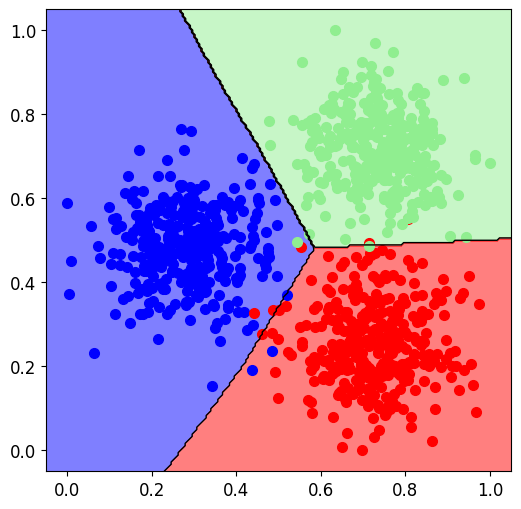

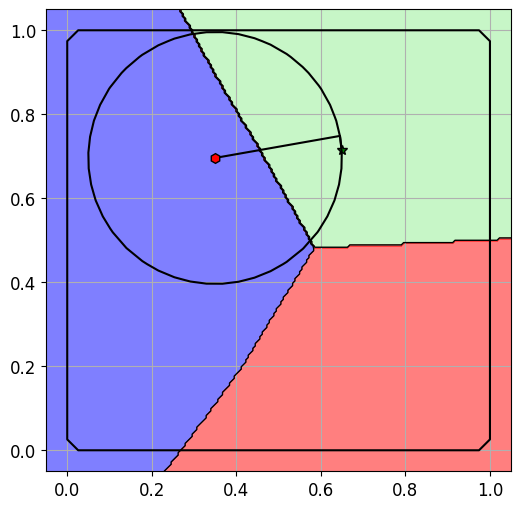

In [8]:
%matplotlib inline

from secml.figure import CFigure
from secml.optim.constraints import CConstraintL2, CConstraintBox

fig = CFigure()
fig.sp.plot_decision_regions(clf, plot_background=True, n_grid_points=200)

# maximum perturbation allowed
constraint = CConstraintL2(center=x0, radius=eps)
fig.sp.plot_path(attack_path)
fig.sp.plot_constraint(constraint)

# feature bounds
input_bounds = CConstraintBox(lb=0.0, ub=1.0)
fig.sp.plot_constraint(input_bounds)
fig.show()

Evasion achieved!
As you could see, the process is not bug-free, and it is complex to handle.
Hence, SecML provides a lot of attack wrappers to accomplish the same task effortlessly.

In [9]:
from secml.adv.attacks.evasion import CFoolboxPGDL2 # SecML include attacks

index = 0
point = ts[index, :]
x0, y0 = point.X, point.Y
steps = 200
eps = 0.3
alpha = 0.1

y_target = None
lb = tr.X.min()  # lower bound of the input space
ub = tr.X.max()  # upper bound of the input space

pgd_attack = CFoolboxPGDL2(clf, y_target,
                           lb=lb, ub=ub,
                           epsilons=eps,
                           abs_stepsize=alpha, # perturbation
                           steps=steps, # step_size
                           random_start=False)

y_pred, _, adv_ds_pgd, _ = pgd_attack.run(x0, y0)

print("Original x0 label: ", y0.item())
print("Adversarial example label (PGD-L2): ", y_pred.item())

Original x0 label:  0
Adversarial example label (PGD-L2):  2


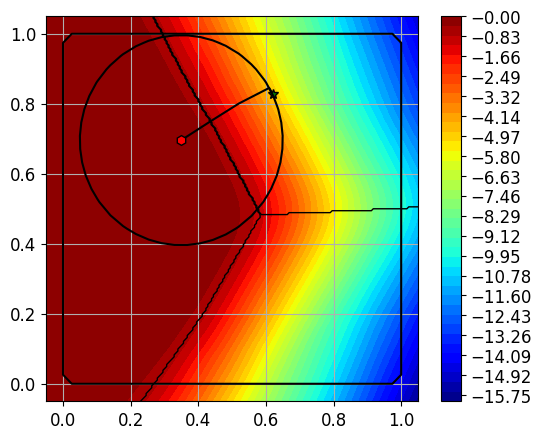

In [10]:
%matplotlib inline
# let's plot again
fig = CFigure(height=5, width=6)
fig.sp.plot_decision_regions(clf, plot_background=False, n_grid_points=200)

# let's plot the objective function of the attack
fig.sp.plot_fun(pgd_attack.objective_function, n_grid_points=200, plot_levels=False)

constraint = CConstraintL2(center=x0, radius=eps)
fig.sp.plot_path(pgd_attack.x_seq)
fig.sp.plot_constraint(constraint)
input_bounds = CConstraintBox(lb=0.0, ub=1.0)
fig.sp.plot_constraint(input_bounds)
fig.show()

## Exercise

Use the tutorial above and [the first tutorial](01_intro_secml.ipynb) to create evasion attacks against a Deep Neural Network trained on the MNIST classifier.

1. Load the MNIST dataset and create a Neural Network with PyTorch.
2. Train the model on the MNIST dataset with SecML.
3. Use the PGD-LInf attack with $\varepsilon=0.3$, $\alpha=0.01$ and 200 steps to create an adversarial digit.
4. (optional) Use the utility function used before to show the original and perturbed digit along with their predictions.
5. Check out the other attacks available in [SecML](https://secml.readthedocs.io/)!


### Attack 1. Using FoolBox Library

In [36]:
# TODO write your code here
# import MNIST data

from keras.datasets import mnist

n_tr = 3000  # number of training samples
n_ts = 1000  # number of testing samples


# We import some data from the data loader
from secml.data.loader import CDataLoaderMNIST

loader = CDataLoaderMNIST()
tr = loader.load('training')
ts = loader.load('testing', num_samples=n_ts)

# normalize the data. Not the best way to normalize! It's not using the normalizer function
tr.X /= 255
ts.X /= 255

In [37]:
# create a neural network with pytorch
# to create a NN first we define a class

from torch import nn
import torch

class Net(nn.Module):
    """Model with input size (-1, 28, 28) for MNIST 10-classes dataset."""
    def __init__(self):
        super(Net, self).__init__()
        # Define the neural network layers
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) # First convolutional layer
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) # Second convolutional layer
        self.conv2_drop = nn.Dropout2d() # Dropout layer
        self.fc1 = nn.Linear(320, 50) # First fully connected layer
        self.fc2 = nn.Linear(50, 10) # Second fully connected layer

    def forward(self, x):
        # Define the forward pass of the neural network
        x = torch.relu(torch.max_pool2d(self.conv1(x), 2)) # Apply convolution and max-pooling, and apply ReLU activation
        x = torch.relu(torch.max_pool2d(self.conv2_drop(self.conv2(x)), 2))  # Apply second convolution, dropout, max-pooling, and ReLU activation
        x = x.view(-1, 320) # Flatten the output
        x = torch.relu(self.fc1(x)) # Apply first fully connected layer and ReLU activation
        return self.fc2(x) # Output from the second fully connected layer

import torch.optim as optim

# Create an instance of the neural network
net = Net()
# Define the optimizer for training
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# Define the loss function
loss_function = nn.CrossEntropyLoss()

**Summary:**

This code defines a neural network class (named Net) for the MNIST dataset, which is used for image classification. It consists of two convolutional layers, a dropout layer, and two fully connected layers. The network takes 28x28 pixel grayscale images as input and is designed to classify them into one of ten possible classes.

**Characteristics:**

* Input size: (-1, 28, 28)
* Two convolutional layers with ReLU activation and max-pooling.
* A dropout layer to prevent overfitting.
* Two fully connected layers with ReLU activation.
* Output layer with ten output units for class prediction.
* Uses the stochastic gradient descent (SGD) optimizer with a learning rate of 0.001 and momentum of 0.9.
* Employs the Cross-Entropy loss function for classification.

**Changeable Parameters:**

* You can change the architecture of the neural network by modifying the number of layers, units, or activation functions.
* The learning rate (lr) and momentum for the optimizer can be adjusted for better training.
* Different optimizers and loss functions can be used depending on the problem.
* Batch size, number of epochs, and dataset preprocessing can also be changed for training.

In [38]:
# we now train the model with SecML
from secml.ml.classifiers import CClassifierPyTorch
clf = CClassifierPyTorch(model=net,
                         loss=loss_function,
                         optimizer=optimizer,
                         epochs=3,
                         batch_size=20,
                         input_shape=(1, 28, 28),
                         random_state=0)

clf.fit(tr.X, tr.Y)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [39]:
# evaluation
from secml.ml.peval.metrics import CMetricAccuracy

# compute predictions on a test set
y_pred = clf.predict(ts.X)

# Evaluate the accuracy of the classifier
metric = CMetricAccuracy()
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)

print("Accuracy on test set: {:.2%}".format(acc))

Accuracy on test set: 96.60%


In [40]:
# Attack 1
from secml.adv.attacks.evasion import CFoolboxPGDL2 # SecML include attacks

index = 0
point = ts[index, :]
x0, y0 = point.X, point.Y
steps = 200
eps = 0.3
alpha = 0.01

y_target = None
lb = tr.X.min()  # lower bound of the input space
ub = tr.X.max()  # upper bound of the input space

pgd_attack = CFoolboxPGDL2(clf, y_target,
                           lb=lb, ub=ub,
                           epsilons=eps,
                           abs_stepsize=alpha, # perturbation
                           steps=steps, # step_size
                           random_start=False)

y_pred, _, adv_ds_pgd, _ = pgd_attack.run(x0, y0)

print("Original x0 label: ", y0.item())
print("Adversarial example label (PGD-L2): ", y_pred.item())

Original x0 label:  7
Adversarial example label (PGD-L2):  7


### Attack 2. Using SecML Library

In [47]:

index = 0
point = ts[index, :]
x0, y0 = point.X, point.Y

lb = tr.X.min()  # lower bound of the input space
ub = tr.X.max()  # upper bound of the input space

# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.5,
    'eta_min': 2.0,
    'eta_max': None,
    'max_iter': 200,
    'eps': 0.3
}

from secml.adv.attacks import CAttackEvasionPGDLS
pgd_ls_attack = CAttackEvasionPGDLS(classifier=clf,
                                    double_init_ds=tr,
                                    distance='l2', # type of perturbation
                                    dmax=3.0, # maximum perturbation
                                    solver_params=solver_params,
                                    y_target=None) # as it is an untargeted attack

y_pred, _, adv_ds_pgd, _ = pgd_ls_attack.run(x0, y0)

print("Original x0 label: ", y0.item())
print("Adversarial example label (PGD-L2): ", y_pred.item())
print("Attack complete!")

Original x0 label:  7
Adversarial example label (PGD-L2):  3
Attack complete!


***Changeable Parameters for Adversarial Attack***

In the provided code, several parameters and settings are changeable and adaptable depending on the data and the specific requirements of your adversarial attack. Here's a breakdown of the changeable parts:

1. `index`, `point`, `x0`, `y0`: These variables determine the index of the data point you want to attack and its corresponding input features and true label. You can change the `index` to select different data points for the attack.

2. `steps`: This parameter controls the number of optimization steps or iterations for the adversarial attack. You can adjust it based on the desired trade-off between attack effectiveness and computational resources.

3. `eps`: The epsilon value sets the perturbation budget for the L2-norm constraint. You can adapt it to change the allowed perturbation magnitude. Smaller values result in more subtle perturbations, while larger values may produce more noticeable changes.

4. `alpha`: The absolute step size determines how much each step in the attack perturbs the input. You can modify it to control the aggressiveness of the attack. Smaller values may result in slower convergence but also smaller perturbations, while larger values may lead to faster convergence but risk making the perturbation too obvious.

5. `y_target`: This variable is set to `None`, indicating an untargeted attack. If you want to perform a targeted attack, you can specify the target class label here.

6. `lb` and `ub`: These variables define the lower and upper bounds of the input space. Depending on your data, these bounds can be adjusted to ensure that the adversarial perturbations remain within the valid input range.

7. The `CFoolboxPGDL2` object is initialized with various parameters such as `epsilons`, `abs_stepsize`, and `steps`. These parameters control the specific characteristics of the PGD attack and can be adapted based on the desired attack strategy.

By modifying these parameters, you can customize the adversarial attack to suit your specific use case and dataset. The choice of these parameters should be guided by the characteristics of your data and the desired trade-offs between attack success, perturbation size, and computational resources.


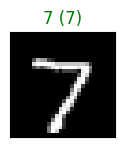

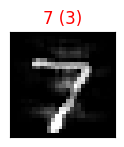

In [48]:
from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

# Let's define a convenience function to easily plot the MNIST dataset
def show_digits(samples, preds, labels, digs, n_display=8):
    samples = samples.atleast_2d()
    n_display = min(n_display, samples.shape[0])
    fig = CFigure(width=n_display*2, height=3)
    for idx in range(n_display):
        fig.subplot(2, n_display, idx+1)
        fig.sp.xticks([])
        fig.sp.yticks([])
        fig.sp.imshow(samples[idx, :].reshape((28, 28)), cmap='gray')
        fig.sp.title("{} ({})".format(digits[labels[idx].item()], digs[preds[idx].item()]),
                     color=("green" if labels[idx].item()==preds[idx].item() else "red"))
    fig.show()

digits = list(range(10))
# change this twoo lines to show the attack
show_digits(point.X[0, :], clf.predict(point.X[0, :]), point.Y[0, :], digits)
show_digits(adv_ds_pgd.X[0, :], clf.predict(adv_ds_pgd.X[0, :]), adv_ds_pgd.Y[0, :], digits)